#  Computational Analysis of Magnetic Topology in a Helical Stellarator
This project presents a computational simulation designed to model and visualise the magnetic flux surfaces of a Helical Stellarator. The configuration consists of two double-helical coils and thirty equally-spaced toroidal planar coils. 

The simulation numerically implements a discretisation of the Biot-Savart law, utilising Euler's method for integration to calculate the magnetic flux surfaces generated by the coils. The primary output is a 3D plot displaying the magnetic topology, demonstrating how plasma is confined within the device.

## Notes



I will first create a function which aims to compute the Biot-Savart law. I will then validate this function by comparing with a result that can be determined by hand, such as the magentic field in the Z-direction of a circular, current-carrying loop located in the X-Y plane.

The Biot-Savart can will be discretised into the following summation:
$$\bold{B}(r) \approx \frac{\mu_{0}I}{4\pi}\sum^{N}_{i=1}{\frac{dl_{i}\times (\bold{r}-\bold{r'_{i}})}{|\bold{r}-\bold{r'_{i}}|^{3}}}$$

Where:\
$\mu_{0}$ is the permeability of free space\
$I$ is the current in the wire\
$dl_{i}$ is an infinitessimal wire segment\
$\bold{r}$ is the point at which the field is being computed\
$\bold{r'_{i}}$ is the centre of the $i$-th wire segment


In [92]:
# IMPORTING THE NECESSARY LIBRARIES
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as Rot
from scipy.integrate import solve_ivp

The implementation of the Biot-Savart law will be done through a function that takes the coordinates of the points on the coil, the position where the magnetic field is to be calculated at, as well as the permeability and current in the coil.

In [94]:
def BSL(mu, I, coil_points, target_point):
    """
    FUNCTION TO CALCULATE THE MAGNETIC FIELD DUE TO THE PRESENCE OF A CURRENT.
    - The routine np.roll is used in order to cycle the elements in the array to the left which avoids explicitly
        using a loop, increasing the performance.
    - The calculated length segments dl are crossed with the distance between the target point and midpoints of the
        line segments using the np.cross() routine.
    - The result of the cross products and the magnitudes of the distances from the target point and midpoint are stored
        in arrays, whose elements are divided and their sum is found, providing the magnetic field.

    ARGEUMENT(S)
    [mu] - The permeability of the space which the current is located in 
    [I] - The value of the current
    [coil_points] - An array of the coodinate points which make up the coil: [[x1, y1, z1], [x2, y2, z2], ...]
    [target_point] - An array containing a singular point which the magnetic field is to be calculated at [xt, yt, zt]

    RETURN(S)
    [B] - The magentic field at the target point in vector form
    """

    coil_points = np.asarray(coil_points, dtype=float)
    target_point = np.asarray(target_point, dtype=float).reshape(3,)

    
    dl = np.roll(coil_points, -1, axis=0) - coil_points
    midpoints = (np.roll(coil_points, -1, axis=0) + coil_points)/2

    r = target_point - midpoints

    dist = np.linalg.norm(r, axis=1)
    dist_safe = np.maximum(dist, 1e-9)

    cross_prod = np.cross(dl, r)

    B = (mu*I/(4*np.pi)) * np.sum(cross_prod/(dist_safe**3)[:, np.newaxis], axis=0)

    if not np.all(np.isfinite(B)):
        return np.zeros(3)

    return B


The function's output needs to be checked with a standard result that can be determined by-hand. The chosen scenario will be a standard planar coil of radius 0.2m carrying a current of 1000A and the field at the centre of the coil will be calculated and checked.

Magnetic field at the centre of the coil: 0.00314T 

Plot of the planar coil:


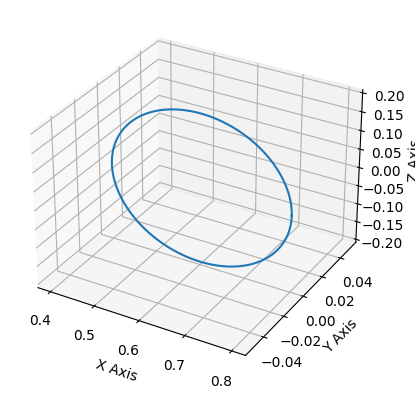

In [ ]:

n_points = 10000
Rm = 0.6
rm = 0.2
warp_amp = 0

t = np.linspace(0, 2*np.pi, n_points, endpoint=False)
x = Rm + rm*np.cos(t)
z = rm * np.sin(t)

y = warp_amp * np.cos(2*t)

coil_points = np.column_stack((x, y, z))

mu = (4*np.pi) * (10**(-7))

b = BSL(mu, 1000, coil_points, [0.6, 0, 0])
print(f"Magnetic field at the centre of the coil: {np.linalg.norm(b):.3}T \n")

print("Plot of the planar coil:")
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

ax.plot(x, y, z,)

Using the Biot-Savart law, it can be verified that the magnetic field inside the centre of a circular current-carrying loop can be determined using the equation: $$B_{0}=\frac{\mu_{0}I}{2R}$$

Where $R$ is the radius of the circular loop

Substituting in the following values:\
$\mu_{0} = 4\pi\times10^{-7} \text{Hm}^{-1}$ \
$I = 1000\text{A}$\
$R = 0.2\text{m}$
$$B_{0, \text{theoretical}} = \pi\times 10^{-3}T$$
Which agrees with the simulated result of 0.00314T

With the simulated results agreeing with theory, I will now write the coil and the stellarator as classes in order to instantiate multiple coils in a simpler way.

In [ ]:
# FUNCTION TO SET THE AXES OF A 3D PLOT EQUAL TO EACH OTHER IN ORDER TO SHOW THE CIRCULAR NATURE OF THE TOROID
def set_axes_equal(ax):
    # Retrieve the current auto-scaled limits of the data
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    # Calculate the range and centre point for each axis
    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # Determine the 'bounding box' radius
    plot_radius = 0.5 * max([x_range, y_range, z_range])

    # Force limits to be equal for all axes
    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [ ]:
class Stell:
    '''
    Class for the Stellarator

    ATTRIBUTES:
    [coils] - An array containing objects of the 'coil' class which will make up the toroidal coils
    [rMaj] - Major Radius - the radius from the centre of the torus to the centre of the tube
    [turns] - the number of turns the double-helical coils will make
    [rMin] - Minor Radius - the radius of the tube itself
    [current] - the current of the coils

    METHODS:
    PLACE - places the helixes and the coils onto the torus, adds the coodinate points 
            for the coils into dictionaries
    PLOT - plots the coils onto a 3D Matplotlib graph, also adds a wireframe of the torus
    FIELD - Calculates the field at a certain point due to each coil
    '''
    def __init__(self, coils, rMaj, turns, rMin, current):
        self.coils = coils
        self.rMaj = rMaj
        self.turns = turns
        self.rMin = rMin
        self.current = current

        self.helixData = []
        self.coilData = []
        

    def place(self):
        R = self.rMaj
        r = self.rMin
        N = self.turns

        theta = np.linspace(0, 2*np.pi, 2000)

        # Helix 1
        phi1 = N * theta
        x1 = (R + r * np.cos(phi1)) * np.cos(theta)
        y1 = (R + r * np.cos(phi1)) * np.sin(theta)
        z1 = r * np.sin(phi1)

        # Helix 2
        phi2 = N * theta + np.pi 
        x2 = (R + r * np.cos(phi2)) * np.cos(theta)
        y2 = (R + r * np.cos(phi2)) * np.sin(theta)
        z2 = r * np.sin(phi2)

        h1p = np.column_stack((x1, y1, z1))
        h2p = np.column_stack((x2, y2, z2))

        self.helixData.append({
            "points1": h1p,
            "current1": self.current,
            "points2": h2p,
            "current2": (self.current * -1)
        })
        
        for coil in self.coils:
            t = np.linspace(0, 2*np.pi, coil.nPoints, endpoint=False)

            x = self.rMaj + coil.rMin*np.cos(t)
            z = coil.rMin*np.sin(t)
            y = coil.warpAmp*np.cos(2*t)

            coilPoints = np.column_stack((x, y, z))

            rotations = Rot.from_euler('z', coil.angle, degrees=True)
            coilPoints = rotations.apply(coilPoints)

            self.coilData.append({
                "points": coilPoints,
                "current": coil.current,
            })
            


    def plot(self):
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111, projection='3d')

        
        for item in self.coilData:
            points = item["points"]
            ax.plot(points[:, 0], points[:, 1], points[:, 2], color='red', linewidth=4)

        
        for item in self.helixData:
            points1 = item["points1"]
            ax.plot(points1[:, 0], points1[:, 1], points1[:, 2], color='limegreen', linewidth=4, label='Current Direction A')

            points2 = item["points2"]
            ax.plot(points2[:, 0], points2[:, 1], points2[:, 2], color='forestgreen', linewidth=4, label='Current Direction A') 

        u_torus = np.linspace(0, 2 * np.pi, 50)
        v_torus = np.linspace(0, 2 * np.pi, 30)
        U_torus, V_torus = np.meshgrid(u_torus, v_torus)
        X_torus = (self.rMaj + self.rMin * np.cos(V_torus)) * np.cos(U_torus)
        Y_torus = (self.rMaj + self.rMin * np.cos(V_torus)) * np.sin(U_torus)
        Z_torus = self.rMin * np.sin(V_torus)
        ax.plot_wireframe(X_torus, Y_torus, Z_torus, color='blue', alpha=0.1, rstride=2, cstride=2)

        # Cleanup
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Stellarator Design')
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        set_axes_equal(ax)

        plt.show()
        

    def field(self, targetPosition):
        totalB = np.zeros(3)
        mu = (4*np.pi) * (10**(-7))
        targetPosition = np.asarray(targetPosition)

        
        for item in self.coilData:
            points = item["points"]
            current = item["current"]
            B = BSL(mu, current, points, targetPosition)
            totalB += B
        

        for item in self.helixData:
            points1 = item['points1']
            current1 = item['current1']
            B1 = BSL(mu, current1, points1, targetPosition)

            points2 = item['points2']
            current2 = item['current2']
            B2 = BSL(mu, current2, points2, targetPosition)

            totalB += (B1 + B2)
        
        return totalB

In [ ]:
class Coil:
    '''
    Class for each individual coil

    ATTRIBUTES
    [nPoints] - the number of coordinate points making up each coil
    [rMin] - the radius of the coil
    [warpAmp] - a measure of how warped the coil is
    [angle] - the angle at which the coil is rotated from the position of the first coil
    '''
    def __init__(self, nPoints, rMin, warpAmp, current, angle):
        self.nPoints = nPoints
        self.rMin = rMin
        self.warpAmp = warpAmp
        self.angle = angle
        self.current = current

I will now visualise the topology of the magnetic field lines, I've chosen to use Euler's method for integration, which consists of starting at a certain point within the Stellarator, finding the magnetic field and moving a short distance in its direction and finding the magnetic field at that point again. 

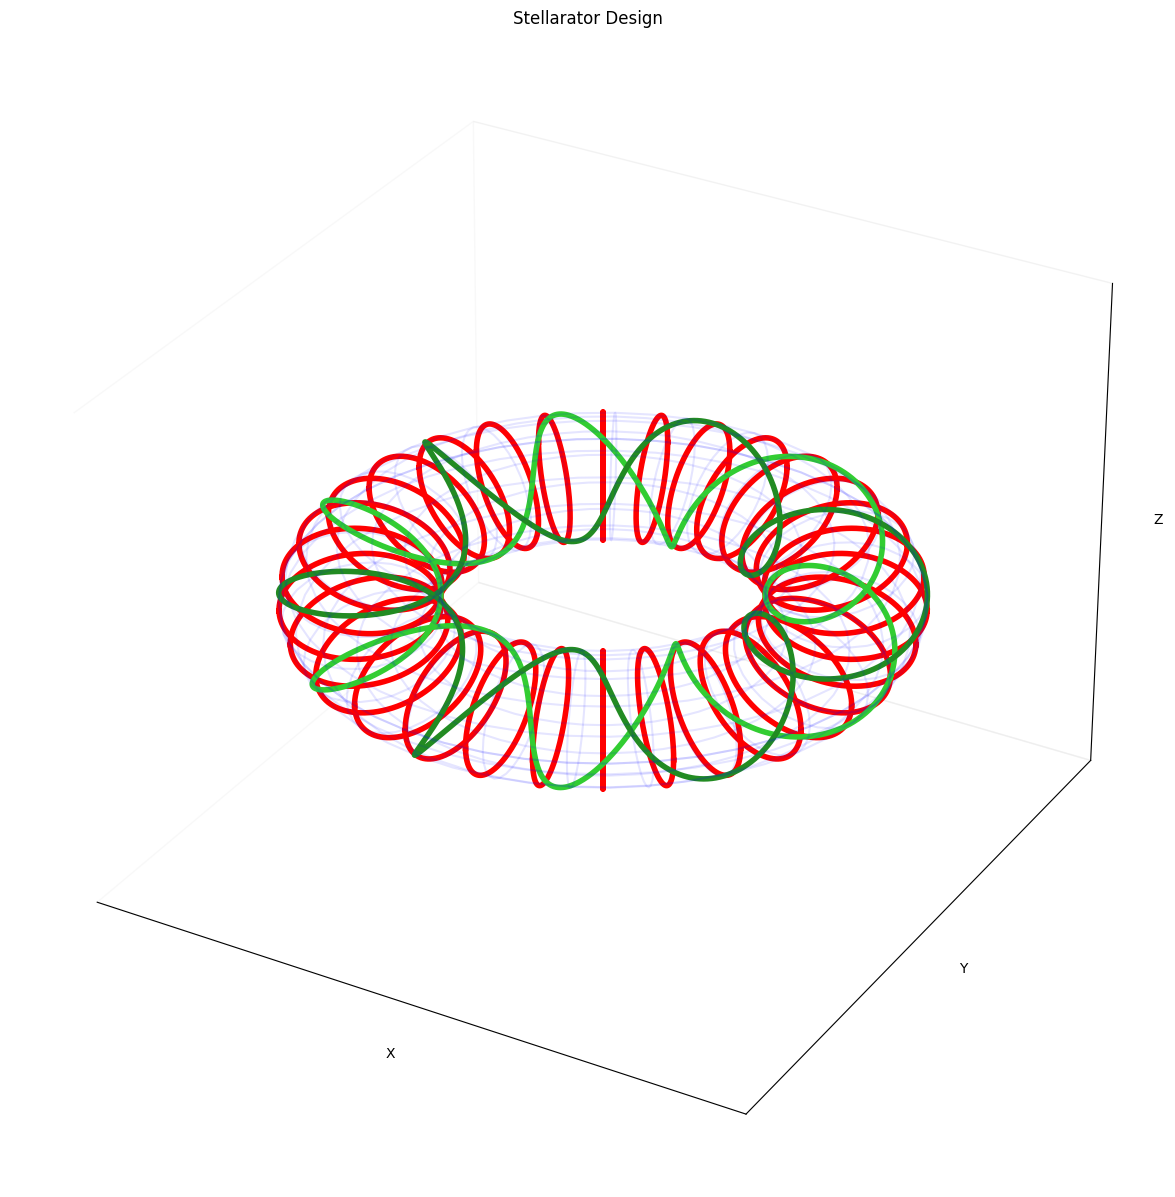

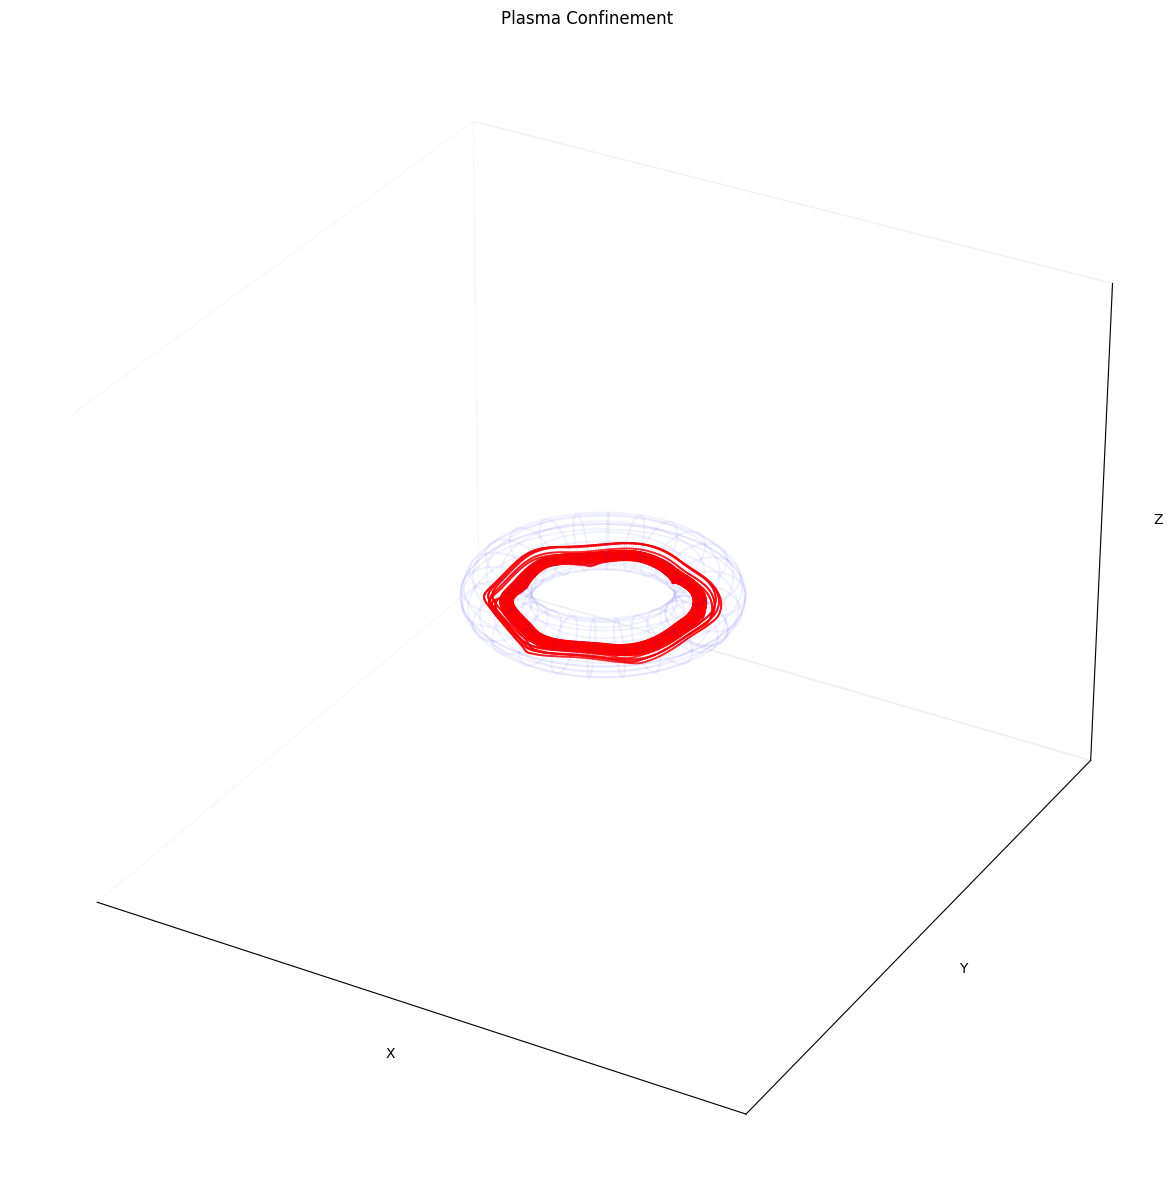

In [ ]:
coils = []      # Array holding all the toroidal coils

# Creates thirty equidistant coils
for i in range(30):
    angle = i * (360/30)
    coils.append(Coil(1000, 0.2, 0, 1000, angle))

# Instantiates the Stellarator class, places the coils, and plots the configuration
tor = Stell(coils, 0.6, 6, 0.2, 1000)
tor.place()
tor.plot()

# Creates a new plot for the magnetic field lines
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')


ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)



startPoints = [             # Array to hold all the starting points of Euler's method
    [0.58, 0, 0],
    [0.6, 0, 0],
    [0.62, 0, 0]
]


colours = ['red', 'red', 'red']     # Array to hold the colours corresponding to each starting point

# Computes Euler's method for each starting point
for startPoint, colour in zip(startPoints, colours):
    positions = []
    currentPos = np.array(startPoint, dtype=float)

    for i in range(0, 45000):
        # Adds the starting point to the 'positions' array
        positions.append(currentPos.copy())

        # Finds the field at that point and calculates its magnitude
        currentField = tor.field(currentPos)
        normB = np.linalg.norm(currentField)
        
        # Increments the current position by 1cm
        uCF = currentField/normB
        uCF /= 100
        currentPos += uCF

    # Plots all of the points
    positions = np.array(positions)
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c=colour, marker='.', s=1, alpha=1)


# Plots the wireframe torus
u_torus = np.linspace(0, 2 * np.pi, 50)
v_torus = np.linspace(0, 2 * np.pi, 30)
U_torus, V_torus = np.meshgrid(u_torus, v_torus)
X_torus = (0.6 + 0.2 * np.cos(V_torus)) * np.cos(U_torus)
Y_torus = (0.6 + 0.2 * np.cos(V_torus)) * np.sin(U_torus)
Z_torus = 0.2 * np.sin(V_torus)
ax.plot_wireframe(X_torus, Y_torus, Z_torus, color='blue', alpha=0.05, rstride=2, cstride=2)

# Cleanup
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Plasma Confinement')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
set_axes_equal(ax)

plt.show()


WHAT SPECIFIC COILS WILL ALLOW FOR CONFINEMENT?
